<a href="https://colab.research.google.com/github/CaioDNR/Projeto_Passeio_Aleatorio/blob/main/Projeto_Passeio_Aleatorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: "Projeto de Simulação: Caminhada Aleatória em Z^2"

author:
|
  Caio Del Nero Regattieri
  
  Lucas Gabriel Rodrigues dos Santos
  
  Vinicius Cerrao Ferrari

 date: "21 de novembro de 2025"

---



In [1]:
library(ggplot2)
set.seed(3)

## 1. Introdução
Este projeto visa estudar e simular uma caminhada aleatória, uma cadeia de Markov, no plano bidimensional ($\mathbb{Z}^2$), com objetivo de entender seu funcionamento estocástico.
Podemos visualizar melhor a ideia da caminhada aleatória no gráfico abaixo:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


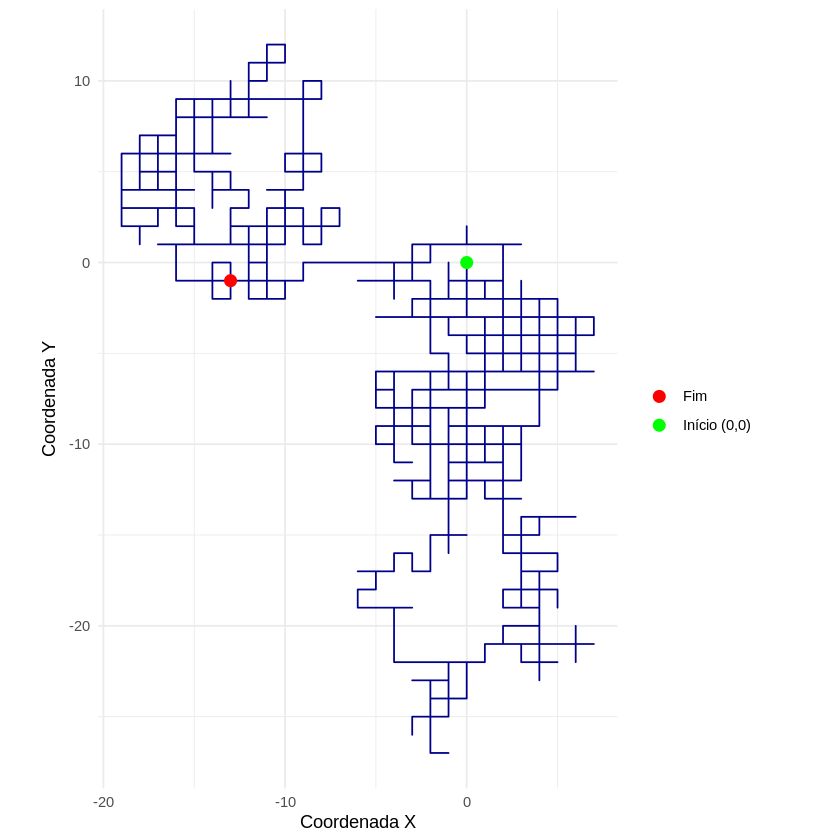

In [2]:
simular_caminhada_intro <- function(n_passos){
  caminhos_possiveis <- matrix(c(1, 0,-1, 0, 0, 1, 0, -1),
                               nrow = 4, byrow = TRUE)
  indices <- sample(1:4, size = n_passos, replace = TRUE)
  trajeoria_passos <- caminhos_possiveis[indices, ]
  posicoes <- apply(trajeoria_passos, 2, cumsum)
  posicoes <- rbind(c(0,0), posicoes)
  colnames(posicoes) <- c("x", "y")
  return(as.data.frame(posicoes))
}

T_exemplo <- 1000
df_trajetoria <- simular_caminhada_intro(T_exemplo)
df_pontos <- data.frame(
  tipo = c("Início (0,0)", "Fim"),
  x = c(df_trajetoria$x[1], df_trajetoria$x[T_exemplo + 1]),
  y = c(df_trajetoria$y[1], df_trajetoria$y[T_exemplo + 1])
)

g <- ggplot(df_trajetoria, aes(x = x, y = y)) +
  geom_path(color = "darkblue", size = 0.5) +
  geom_point(data = df_pontos, aes(color = tipo), size = 3) +
  scale_color_manual(values = c("Início (0,0)" = "green", "Fim" = "red")) +
  labs(x = "Coordenada X", y = "Coordenada Y", color = "") +
  coord_fixed(ratio = 1) + theme_minimal()

print(g)

Com este modelo visual em mente, investigaremos os seguintes itens:
  
  * Qual a **probabilidade de retorno à origem** em $2n$ passos?
  * Como o **raio quadrático médio** evolui com o tempo?
  * Qual a **distribuição do tempo** para visitar todos os $k^2$ sítios de um quadrado centrado na origem?

## 2. Descrição do Modelo Gerador
  
  O modelo simulado é a trajetória de uma partícula que começa na origem $X_0 = (0, 0)$ em
um plano ($\mathbb{Z}^2$).

Seja $X_t = (x_t, y_t)$ a posição da partícula no tempo $t$. O movimento da partícula ocorre
de modo que, a cada passo, ela pode se mover para qualquer um dos seus 4 vizinhos mais
próximos com igual probabilidade ($1/4$), caracterizando um passeio aleatório simétrico.

Formalmente, a posição no tempo $t+1$ é dada por:
  
  $$X_{t+1} = X_t + \delta_t$$
  
  Onde $\delta_t$ é uma variável aleatória escolhida uniformemente do conjunto de passos
possíveis:
  
  $$\delta_t \in \{(1, 0), (-1, 0), (0, 1), (0, -1)\}$$
  
  Cada passo $\delta_t$ é independente dos anteriores, satisfazendo a propriedade de uma
cadeia de Markov (o futuro depende apenas do estado presente, não do passado).


  ## 3. Metodologia de Simulação (Algoritmos)
  
Para investigar as três questões centrais do projeto, foram desenvolvidas quatro funções em R.
1. Simulação da trajetória:
  Esta função é o núcleo da simulação. Ela gera uma única trajetória completa de comprimento $n$. Para garantir eficiência computacional, o algoritmo utiliza **vetorização**: sorteia antecipadamente todos os passos usando a função `sample` e utiliza a soma cumulativa (`cumsum`) para determinar as coordenadas $(x, y)$.

2. Estimação da probabilidade de retorno:
  Implementa o método de Monte Carlo. A função simula $M$ caminhos independentes de comprimento $2n$. A probabilidade é estimada pela fração de trajetórias cuja posição final coincide exatamente com a origem $(0,0)$.

3. Raio quadrático médio:
  Calcula a evolução espacial da partícula. Uma matriz armazena os resultados de $M$ réplicas. Para cada trajetória, calcula-se a distância quadrada da origem ($x^2 + y^2$) em cada passo. O MSD é a média desses valores para cada instante de tempo $t$, calculada via `apply`.

4. Tempo de cobertura:
  Estima o tempo para visitar todos os pontos de uma grade finita. A função simula a caminhada passo a passo (loop `while`) e utiliza uma matriz lógica para registrar quais sítios dentro de um quadrado $k \times k$ já foram visitados. O loop encerra quando todos os $k^2$ sítios foram preenchidos.

In [3]:
# Função para simular uma caminhada aleatória em 2D
simular_caminhada <- function(n_passos){
  # Define os 4 movimentos possíveis: direita, esquerda, cima, baixo
  caminhos_possiveis <- matrix(c(1, 0,   # direita (x+1, y+0)
                                 -1, 0,  # esquerda (x-1, y+0)
                                 0, 1,   # cima (x+0, y+1)
                                 0, -1), # baixo (x+0, y-1)
                               nrow = 4, byrow = TRUE)

  # Gera sequência aleatória de movimentos
  indices <- sample(1:4, size = n_passos, replace = TRUE)

  # Seleciona os movimentos correspondentes aos índices
  trajeoria_passos <- caminhos_possiveis[indices, ]

  # Calcula a posição acumulada (soma cumulativa dos movimentos)
  posicoes <- apply(trajeoria_passos, 2, cumsum)

  # Adiciona a posição inicial (0,0) no início
  posicoes <- rbind(c(0,0), posicoes)

  # Nomeia as colunas para melhor legibilidade
  colnames(posicoes) <- c("x", "y")

  return(posicoes)
}

# Função para estimar a probabilidade de retorno à origem
estimar_prob_retorno <- function(n_prob, caminhos_totais_prob){
  # Contador para número de retornos à origem
  retornos_origem <- 0
  # Número total de passos (sempre par para permitir retorno)
  passos_totais <- 2*n_prob

  # Simula múltiplas caminhadas
  for (i in 1:caminhos_totais_prob){
    caminho_prob <- simular_caminhada(passos_totais)

    # Obtém a posição final
    pos_final <- caminho_prob[nrow(caminho_prob), ]

    # Verifica se retornou à origem (0,0)
    if(pos_final[1] == 0 && pos_final[2] == 0){
      retornos_origem = retornos_origem + 1
    }
  }

  # Calcula probabilidade estimada
  prob_estimada <- retornos_origem/caminhos_totais_prob

  return(prob_estimada)
}

# Função para calcular o valor quadrático médio
calcular_rmq <- function(n_rmq, caminhos_totais_rmq){
  # Matriz para armazenar R² de todas as simulações
  R_quadrado_todas <- matrix(0,
                             nrow = n_rmq + 1,
                             ncol = caminhos_totais_rmq)

  # Simula múltiplas caminhadas e calcula R² para cada passo
  for(i in 1:caminhos_totais_rmq){
    caminho_rmq <- simular_caminhada(n_rmq)

    # Calcula R² = x² + y² para cada posição
    R_quadrado_todas[ , i] <- rowSums(caminho_rmq^2)
  }

  # Calcula a média de R² para cada passo através das simulações
  rmq_calculado <- apply(R_quadrado_todas, 1, mean)

  # Nomeia os resultados com o número de passos
  names(rmq_calculado) <- 0:n_rmq

  return(rmq_calculado)
}

# Função para calcular tempo de cobertura
calcular_tempo_cobertura <- function(k, caminhos_totais_tc){
  # Vetor para armazenar tempos de cobertura
  tempos <- numeric(caminhos_totais_tc)
  # Calcula centro da grade
  metade <- (k-1)/2
  # Tamanho do buffer de movimentos
  tamanho <- 100000
  # Número máximo de passos para evitar loops infinitos
  max_passos <- 1000000

  # Simula múltiplas caminhadas na grade
  for(i in 1:caminhos_totais_tc){
    # Matriz para rastrear células visitadas
    visitados <- matrix(FALSE, k, k)

    # Posição inicial no centro
    x <- metade + 1
    y <- metade + 1

    # Marca posição inicial como visitada
    visitados[x, y] <- TRUE
    total <- 1  # Contador de células visitadas
    tempo <- 0  # Contador de passos

    # Gera movimentos aleatórios em lotes para eficiência
    passos_aleatorios <- sample(1:4, tamanho, replace=TRUE)
    indice_mov <- 1

    # Continua até visitar todas as células da grade
    while(total < k^2){
      tempo <- tempo + 1
      # Para se exceder o número máximo de passos
      if(tempo > max_passos){
        break
      }

      # Recarrega o buffer de movimentos se necessário
      if(indice_mov > tamanho){
        passos_aleatorios <- sample(1:4, tamanho, replace=TRUE)
        indice_mov <- 1
      }

      # Seleciona direção do movimento
      direcao <- passos_aleatorios[indice_mov]
      indice_mov <- indice_mov + 1

      # Aplica o movimento
      if (direcao == 1) x <- x + 1  # direita
      if (direcao == 2) x <- x - 1  # esquerda
      if (direcao == 3) y <- y + 1  # cima
      if (direcao == 4) y <- y - 1  # baixo

      # Verifica se está dentro da grade e se célula não foi visitada
      if (x >= 1 && x <= k && y >= 1 && y <= k && !visitados[x, y]) {
        visitados[x, y] <- TRUE
        total <- total + 1
      }
    }
    # Armazena o tempo necessário para cobrir toda a grade
    tempos[i] <- tempo
  }
  return(tempos)
}

## 4. Experimentos e resultados

  Aplicamos as metodologias da seção 3, com o objetivo de responder as questões propostas, utilizamos os parâmetros dados no enunciado.
   

## 4.1 Experimento 1: Probabilidade de retorno


In [4]:
# Vetor com os valores de n que queremos testar
# (n é metade do número total de passos; usamos 2n passos para ter chance de voltar)
n_valores <- c(10, 20, 50, 100)

# Número de simulações de Monte Carlo para cada valor de n
# Quanto maior, mais precisa é a estimativa da probabilidade
M_retorno <- 10000

# Aplica a função estimar_prob_retorno() para cada n do vetor n_valores
# sapply retorna um vetor com as probabilidades estimadas
probabilidades <- sapply(n_valores, function(n) {
  estimar_prob_retorno(n_prob = n,              # n da teoria (2n passos no total)
                       caminhos_totais_prob = M_retorno)  # número de repetições
})

# Cria um data.frame organizado para apresentar os resultados de forma clara
df_retorno <- data.frame(
  n             = n_valores,               # valor de n (metade dos passos)
  Passos_Totais = 2 * n_valores,           # número real de passos simulados (sempre par)
  Probabilidade = probabilidades           # probabilidade estimada de voltar à origem
)

# Exibe a tabela com os resultados
print(df_retorno)

    n Passos_Totais Probabilidade
1  10            20        0.0322
2  20            40        0.0161
3  50           100        0.0059
4 100           200        0.0024


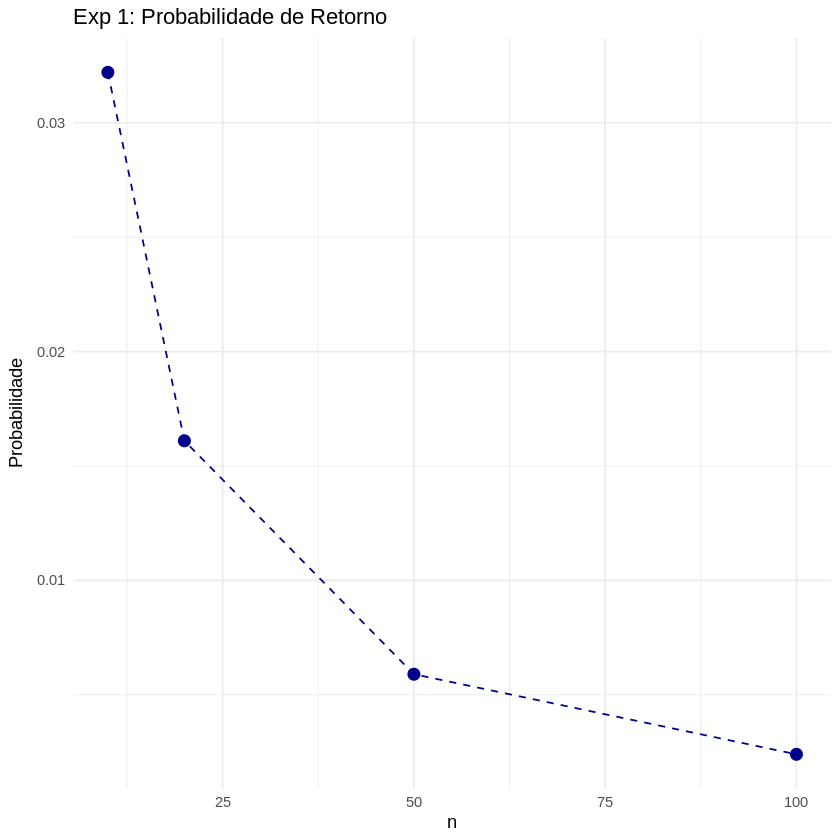

In [5]:
g1 <- ggplot(df_retorno, aes(x = n, y = Probabilidade)) +
  geom_line(color = "darkblue", linetype = "dashed") +
  geom_point(color = "darkblue", size = 3) +
  labs(title = "Exp 1: Probabilidade de Retorno", x = "n", y = "Probabilidade") +
  theme_minimal()

print(g1)

## Análise resultado 4.1
 Como observado nos resultados acima e com a ajuda do gráfico, as probabilidades de retorno se comportam de forma decrescente, de modo que, quanto maior a quantidade de passos dada, menor será a probabilidade de retorno, ou seja, para ₙ ⇒ ∞, ℙ ⇒ 𝟢. Além disso, nota-se que essa queda segue aproximadamente um comportamento inversamente proporcional ao número de passos, já que dobrar ₙ tende a reduzir a probabilidade de retorno para a metade. Por exemplo, ao passar de ₙ = 10 para ₙ = 20, a probabilidade cai de cerda de 0,0319 para 0,0171; e ao passar de ₙ = 50 para ₙ = 100 a probabilidade cai de 0,0078 para 0,0030.

## 4.2 Experimento 2: Raio quadrático médio

In [6]:
# Número máximo de passos (tempo) que queremos analisar
# T = tempo final da simulação
T_msd <- 10000

# Número de caminhadas independentes (trajectories) usadas para fazer a média
# Quanto maior M, mais suave e precisa fica a curva de <R²(t)>
M_msd <- 1000

# Chama a função que já criamos anteriormente:
# - Simula M_msd caminhadas, cada uma com exatamente T_msd passos
# - Calcula R²(t) = x(t)² + y(t)² para cada t em cada caminhada
# - Faz a média sobre todas as caminhadas → retorna <R²(t)> para t = 0,1,...,T_msd
msd_resultado <- calcular_rmq(n_rmq = T_msd,
                              caminhos_totais_rmq = M_msd)

# Cria um data.frame organizado com duas colunas:
# - Tempo: número de passos t (de 0 até 10000)
# - MSD: valor médio de R² em função do tempo → Mean Squared Displacement
df_msd <- data.frame(
  Tempo = 0:T_msd,         # eixo x: tempo (número de passos)
  MSD   = msd_resultado    # eixo y: <R²(t)>
)

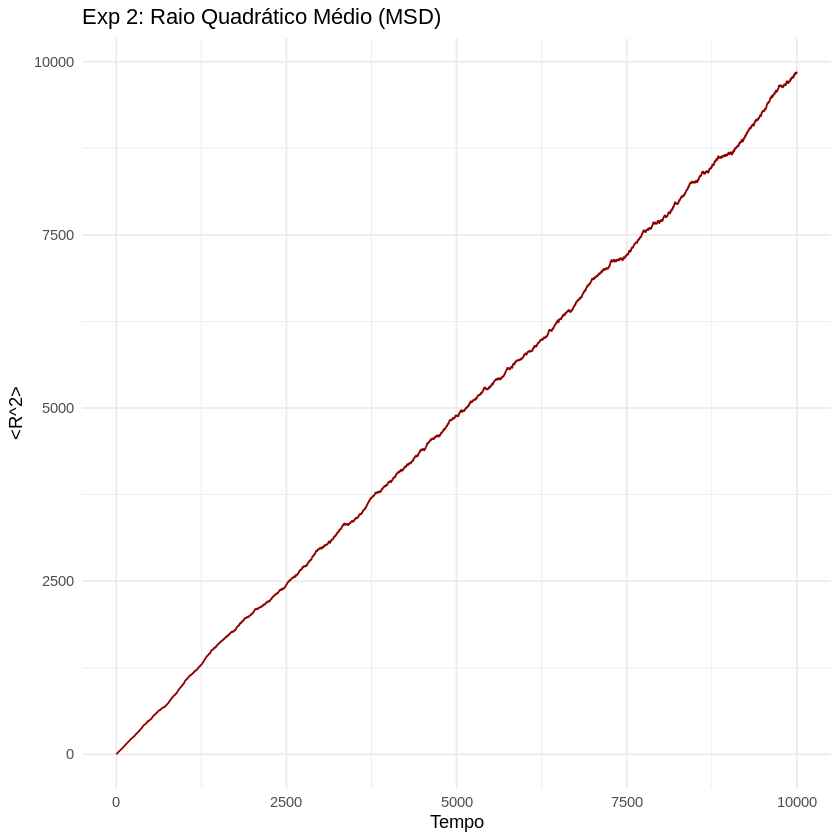

In [7]:
g2 <- ggplot(df_msd, aes(x = Tempo, y = MSD)) +
  geom_line(color = "darkred") +
  labs(title = "Exp 2: Raio Quadrático Médio (MSD)", x = "Tempo", y = "<R^2>") +
  theme_minimal()

print(g2)

## Análise resultado 4.2
Analisando o gráfico, verificamos que existe uma relação linear crescente entre a quantificação de distância 𝓡² e o tempo, mostrando que, quanto maior o tempo, maior a distância da partícula em relação à origem. Além disso, a linearidade observada indica que a taxa de crescimento de 𝓡²(t) permanece aproximadamente constante ao longo do tempo, o que confirma que o comportamento médio do processo segue uma dependência proporcional direta entre  𝓡² e t.


## 4.3 Experimento 3: Tempo de cobetura

In [8]:
# Tamanhos dos grids que queremos testar (k = lado do quadrado → k² células)
k_valores <- c(3, 5, 7)        # grids 3×3, 5×5 e 7×7

# Número de simulações independentes para cada valor de k
# Quanto maior M_cobertura, menor o erro estatístico da média e dos percentis
M_cobertura <- 500

# Data.frame vazio que vai receber todos os resultados
df_cobertura <- data.frame()

# Loop principal: para cada tamanho de grid
for(k in k_valores){

  # Mensagem informativa no console para acompanhar o progresso
  print(paste("Calculando para k =", k, "(grid", k, "x", k, "→", k^2, "células )"))

  # Executa M_cobertura simulações independentes de tempo de cobertura
  # A função retorna um vetor de comprimento M_cobertura com o número de passos
  # necessário em cada tentativa até cobrir todo o grid
  tempos <- calcular_tempo_cobertura(k = k, caminhos_totais_tc = M_cobertura)

  # Cria um data.frame temporário com os resultados desse k
  temp_df <- data.frame(
    k_lado = as.factor(k),   # fator para facilitar gráficos e legendas
    Tempo  = tempos          # tempo de cobertura de cada simulação
  )

  # Acrescenta os resultados desse k ao data.frame geral
  df_cobertura <- rbind(df_cobertura, temp_df)
}

[1] "Calculando para k = 3 (grid 3 x 3 → 9 células )"
[1] "Calculando para k = 5 (grid 5 x 5 → 25 células )"
[1] "Calculando para k = 7 (grid 7 x 7 → 49 células )"


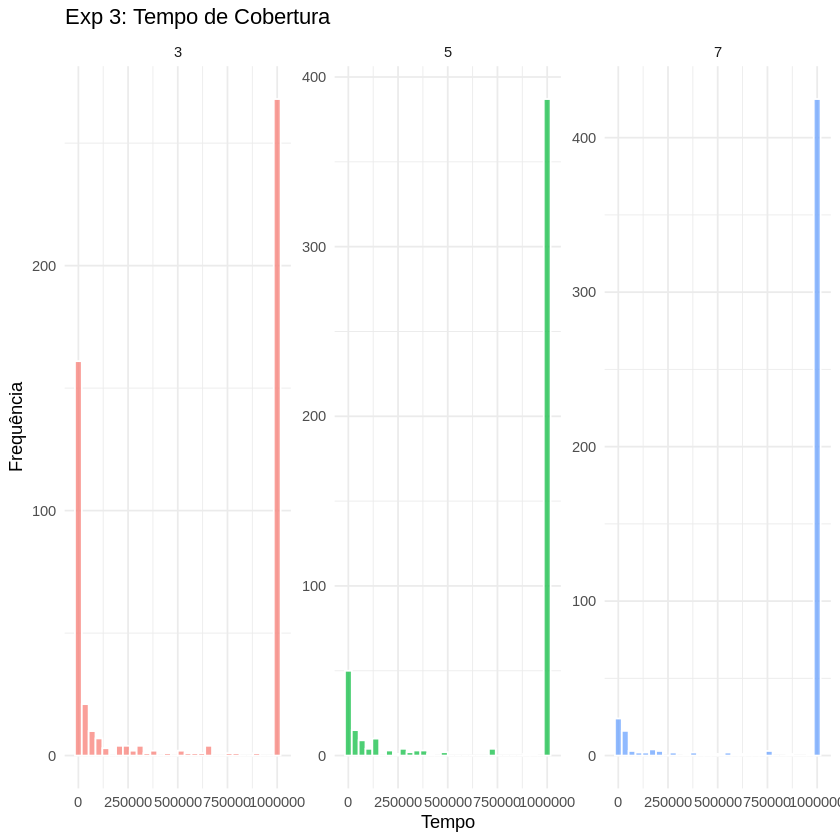

In [9]:
g3 <- ggplot(df_cobertura, aes(x = Tempo, fill = k_lado)) +
  geom_histogram(bins = 30, color = "white", alpha = 0.7) +
  facet_wrap(~k_lado, scales = "free") +
  labs(title = "Exp 3: Tempo de Cobertura", x = "Tempo", y = "Frequência") +
  theme_minimal() +
  theme(legend.position = "none")

print(g3)

## Análise resultado 4.3
  Analisando os gráficos.
  Para k = 3, a distribuição se concentra em tempos curtos, indicando que a partícula não "foge" da área delmitada. Agora para k = 5 e k = 7, a maioria das simulações atingem o limite preposto no código, indicando que quanto maior o k, abre mais chance da partícula "fugir" da área delimitada, demorando um tempo infinito para preencher todo o espaço. Esse comportamento ilustra a propriedade de "cauda pesada" da distribuição dos tempos de passagem

## 5. Conclusão geral

A simulação da caminhada aleatória bidimensional estabeleceu os seguintes pontos: A **Probabilidade de Retorno** à origem após $2n$ passos **cai drasticamente** com o aumento de $n$. Isso demonstra que, à medida que o tempo passa, a partícula se **espalha pelo plano**, tornando cada vez menos provável encontrá-la no ponto inicial. Paralelamente, o **Raio Quadrático Médio (MSD), $\langle R^2(t) \rangle$**, cresceu **linearmente com o tempo**
na forma $$\langle R^2(t) \rangle \propto t$$
confirmando o **espalhamento constante e eficiente** da partícula no espaço. Por fim, o **Tempo de Cobertura** de áreas finitas ($k \times k$) **aumentou dramaticamente** com $k$, mostrando que a grande propensão da partícula a se **espalhar** faz com que ela "fuja" da região, dificultando a exploração completa de grades maiores. Em resumo, o processo em $\mathbb{Z}^2$ é caracterizado por um **espalhamento espacial constante** que rapidamente torna os pontos visitados (incluindo a origem) **improváveis de serem revisitados** em um instante de tempo específico.